In [ ]:
# Install the library with the pretrained weights
!pip install git+https://github.com/facebookresearch/vip.git zarr

  Cloning https://github.com/facebookresearch/vip.git to /tmp/pip-req-build-9wy9xjlc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/vip.git /tmp/pip-req-build-9wy9xjlc
  Resolved https://github.com/facebookresearch/vip.git to commit f98ca99bcaf9f7e00ccd1c99735d77f55c53dd69
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from vip import load_vip
from tqdm import trange
from sklearn.manifold import TSNE
import zarr

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the data
base_path = "/content/drive/MyDrive/sim-2-real-representation-learning/data"
sim1 = zarr.open(base_path + "/one_leg_low_sim.zarr", mode="r")
sim2 = zarr.open(base_path + "/one_leg_med_sim.zarr", mode="r")
real = zarr.open(base_path + "/one_leg_low_real.zarr", mode="r")

# sim1_imgs = sim1["color_image2"]
sim2_imgs = sim2["color_image2"]
real_imgs = real["color_image2"]

# print(f"Loaded {len(sim1['episode_ends'])} trajectories containing {sim1_imgs.shape[0]} frames")
print(f"Loaded {len(sim2['episode_ends'])} trajectories containing {sim2_imgs.shape[0]} frames")
print(f"Loaded {len(real['episode_ends'])} trajectories containing {real_imgs.shape[0]} frames")

Loaded 25 trajectories containing 12263 frames
Loaded 50 trajectories containing 27699 frames


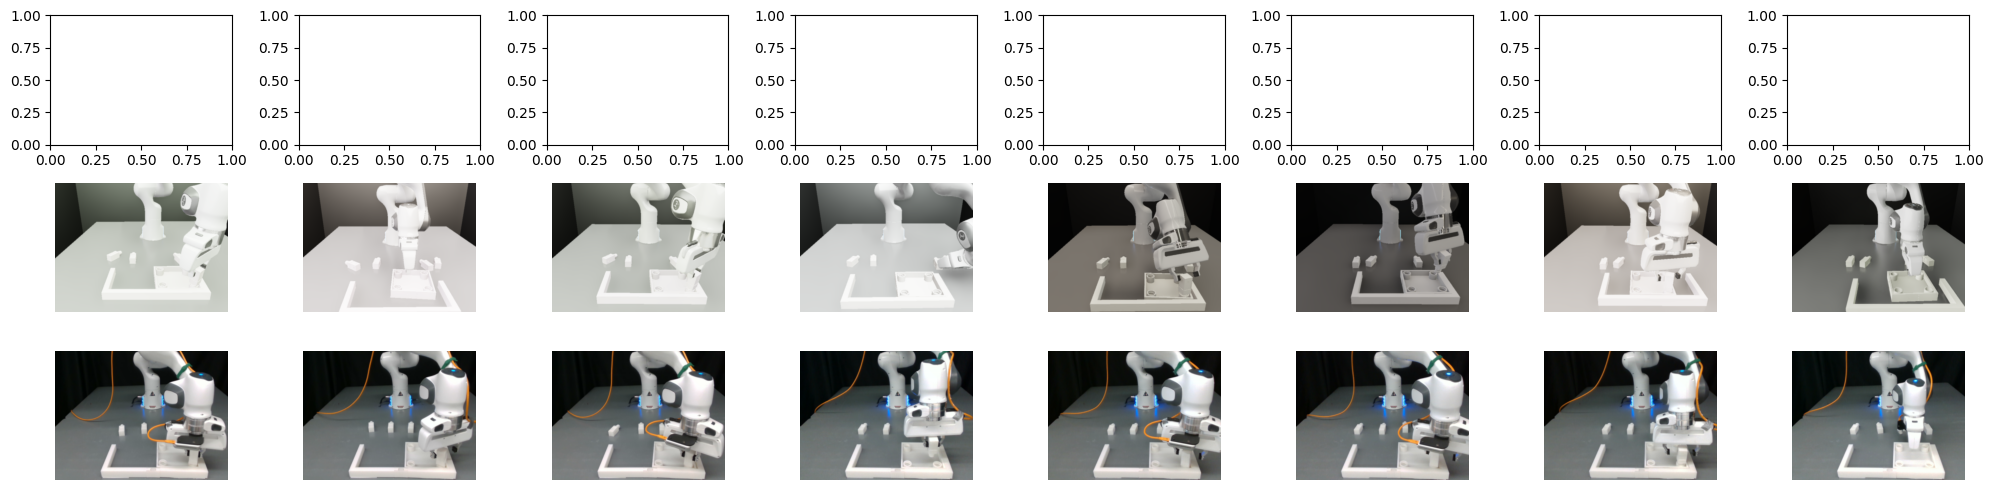

In [ ]:
# Sample 8 images from each dataset
# sim1_indices = np.random.choice(sim1_imgs.shape[0], size=8, replace=False)
sim2_indices = np.random.choice(sim2_imgs.shape[0], size=8, replace=False)
real_indices = np.random.choice(real_imgs.shape[0], size=8, replace=False)

# Create a figure and axes
fig, axes = plt.subplots(3, 8, figsize=(20, 5))

# Display the sampled images
# for i, idx in enumerate(sim1_indices):
#     axes[0, i].imshow(sim1_imgs[idx])
#     axes[0, i].axis('off')

for i, idx in enumerate(sim2_indices):
    axes[1, i].imshow(sim2_imgs[idx])
    axes[1, i].axis('off')

for i, idx in enumerate(real_indices):
    axes[2, i].imshow(real_imgs[idx])
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
vip = load_vip().to(device)
vip.eval()

Downloading: "https://pytorch.s3.amazonaws.com/models/rl/vip/model.pt" to /root/.vip/resnet50/model.pt
100%|██████████| 98.0M/98.0M [00:09<00:00, 10.7MB/s]
Downloading: "https://pytorch.s3.amazonaws.com/models/rl/vip/config.yaml" to /root/.vip/resnet50/config.yaml
100%|██████████| 362/362 [00:00<00:00, 424kB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Non

DataParallel(
  (module): VIP(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1

100%|██████████| 5/5 [06:45<00:00, 81.15s/it]


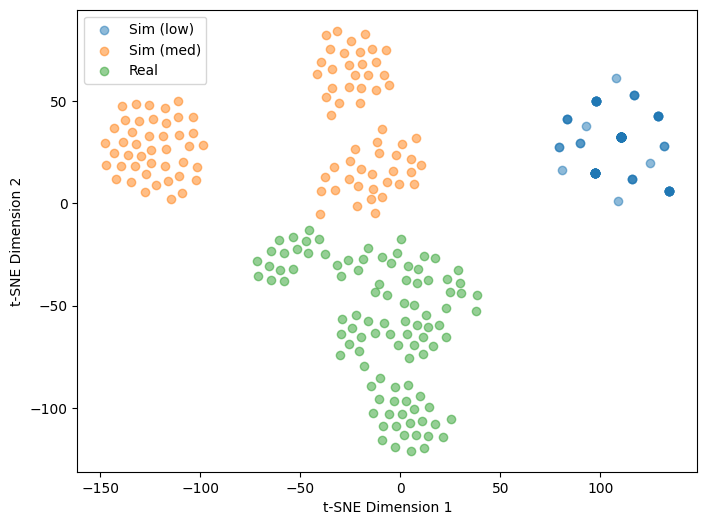

In [ ]:
resize_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL image
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor()  # Convert PIL image back to tensor
])

num_samples = 100
batch_size = 20

# Sample indices for each dataset
# sim1_indices = np.random.choice(sim1_imgs.shape[0], size=num_samples, replace=False)
sim2_indices = np.random.choice(sim2_imgs.shape[0], size=num_samples, replace=False)
real_indices = np.random.choice(real_imgs.shape[0], size=num_samples, replace=False)

# Create tensors to store the embeddings
sample_img = resize_transform(sim2_imgs[0])
vip_output_dim = vip(sample_img.unsqueeze(0).to(device)).shape[1]  # Determine the output dimension
sim1_embeddings = torch.zeros(num_samples, vip_output_dim)
sim2_embeddings = torch.zeros(num_samples, vip_output_dim)
real_embeddings = torch.zeros(num_samples, vip_output_dim)

# Compute embeddings for the sampled images in batches
with torch.no_grad():
    for i in trange(0, num_samples, batch_size):
        # Process sim1 images in batches
        #  batch_indices = sim1_indices[i: i + batch_size]
        # sim_batch = torch.stack([resize_transform(img) for img in sim1_imgs[batch_indices]]).float().cuda()
        # sim1_embeddings[i: i + batch_size] = vip(sim_batch).cpu()

        # Process sim2 images in batches
        batch_indices = sim2_indices[i: i + batch_size]
        sim_batch = torch.stack([resize_transform(img) for img in sim2_imgs[batch_indices]]).float().cuda()
        sim2_embeddings[i: i + batch_size] = vip(sim_batch).cpu()

        # Process real images in batches
        batch_indices = real_indices[i: i + batch_size]
        real_batch = torch.stack([resize_transform(img) for img in real_imgs[batch_indices]]).float().cuda()
        real_embeddings[i: i + batch_size] = vip(real_batch).cpu()

# Embeddings are now stored in sim_embeddings and real_embeddings tensors
# Concatenate the embeddings and create labels
all_embeddings = torch.cat([sim1_embeddings, sim2_embeddings, real_embeddings]).cpu().numpy()
labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples), np.ones(num_samples) * 2])

# Fit t-SNE on the embeddings
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:num_samples, 0], embeddings_2d[:num_samples, 1], label='Sim (low)', alpha=0.5)
plt.scatter(embeddings_2d[num_samples:2*num_samples, 0], embeddings_2d[num_samples:2*num_samples, 1], label='Sim (med)', alpha=0.5)
plt.scatter(embeddings_2d[2*num_samples:, 0], embeddings_2d[2*num_samples:, 1], label='Real', alpha=0.5)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()


Nearest indices: [ 3  4  5  6 13]
Labels of nearest points: [0. 0. 0. 0. 0.]
Furthest indices: [115 142 161 130 188]
Labels of furthest points: [1. 1. 1. 1. 1.]


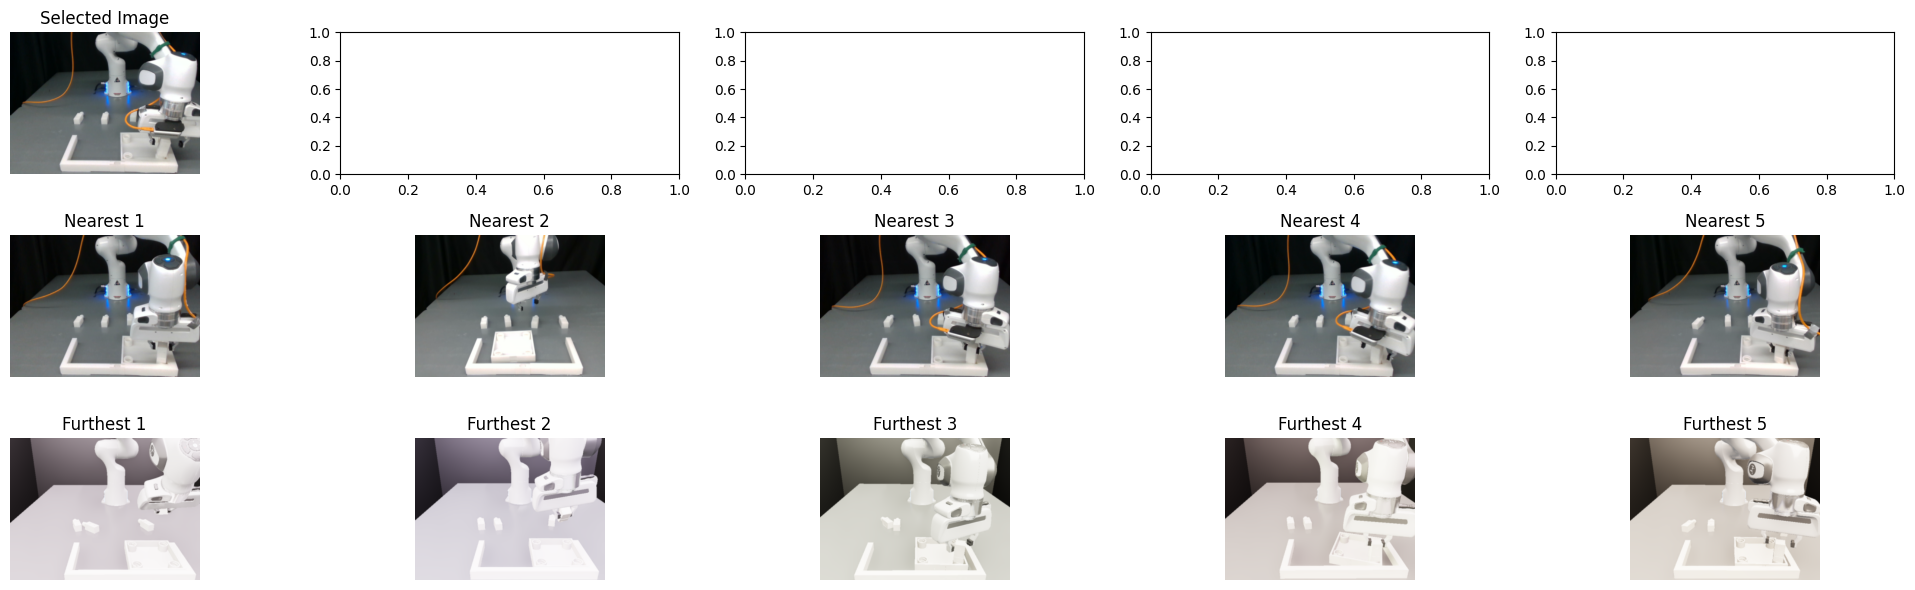

In [ ]:
def find_points(embeddings_2d, selected_point, num_points=5, nearest=True):
    distances = np.linalg.norm(embeddings_2d - selected_point, axis=1)
    if nearest:
        indices = np.argsort(distances)[:num_points]
    else:
        indices = np.argsort(distances)[-num_points:]
    return indices

def visualize_comparison(selected_idx, nearest_indices, furthest_indices, labels, sim2_imgs, real_imgs, num_samples):
    fig, axes = plt.subplots(3, max(len(nearest_indices), len(furthest_indices)), figsize=(20, 6))

    # Show the image corresponding to the selected point
    # if labels[selected_idx] == 0:
    #     selected_img = sim1_imgs[sim1_indices[selected_idx % num_samples]]
    if labels[selected_idx] == 1:
        selected_img = sim2_imgs[sim2_indices[selected_idx % num_samples]]
    else:
        selected_img = real_imgs[real_indices[selected_idx % num_samples]]

    axes[0, 0].imshow(selected_img)
    axes[0, 0].set_title('Selected Image')
    axes[0, 0].axis('off')

    # Show nearest images
    for i, idx in enumerate(nearest_indices):
        # if labels[idx] == 0:
        #     img = sim1_imgs[sim1_indices[idx % num_samples]]
        if labels[idx] == 1:
            img = sim2_imgs[sim2_indices[idx % num_samples]]
        else:
            img = real_imgs[real_indices[idx % num_samples]]

        axes[1, i].imshow(img)
        axes[1, i].set_title(f'Nearest {i+1}')
        axes[1, i].axis('off')

    # Show furthest images
    for i, idx in enumerate(furthest_indices):
        # if labels[idx] == 0:
        #     img = sim1_imgs[sim1_indices[idx % num_samples]]
        if labels[idx] == 1:
            img = sim2_imgs[sim2_indices[idx % num_samples]]
        else:
            img = real_imgs[real_indices[idx % num_samples]]

        axes[2, i].imshow(img)
        axes[2, i].set_title(f'Furthest {i+1}')
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()


# Select a specific point from the plot
selected_point_idx = 25
selected_point = embeddings_2d[selected_point_idx]

# Find nearest and furthest points
nearest_indices = find_points(embeddings_2d, selected_point, num_points=5, nearest=True)
furthest_indices = find_points(embeddings_2d, selected_point, num_points=5, nearest=False)

print(f"Nearest indices: {nearest_indices}")
print(f"Labels of nearest points: {labels[nearest_indices]}")
print(f"Furthest indices: {furthest_indices}")
print(f"Labels of furthest points: {labels[furthest_indices]}")

# Visualize the selected image, nearest images, and furthest images
visualize_comparison(selected_point_idx, nearest_indices, furthest_indices, labels, sim2_imgs, real_imgs, num_samples)